**Modelo de red neuronal Transformer**

Este archivo consta de los codigos y conclusiones de:
* 1.Carga de librerias y datos
* 2.Normalizar Datos.
* 3.Preparar datos para realizar aprendizaje supervizado.
* 4.Modelo Transformer
* 5.Evaluacion del modelo


#1.Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

In [100]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
#Seaborn es utilizado para generar los gráficos
import seaborn as sns
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler
#Módulos implementa funciones que evalúan el error de predicción para propósitos específicos
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
#Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

#Biblioteca de Redes Neuronales
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dropout, LSTM, Dense, Activation,Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit
import time, random,os

In [101]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [102]:
pip install h5py --quiet

In [103]:
cd /content/gdrive/MyDrive/Tesis/Datos

/content/gdrive/MyDrive/Tesis/Datos


Se obtiene conjunto de datos

In [152]:
predictor_variables=pd.read_csv('predictor_variables.csv', index_col='Date')
target_variables=pd.read_csv('target_variables.csv', index_col='Date')
df=pd.read_csv('df_modelo.csv', index_col='Date')

In [153]:
def divide_array(array, num_parts,largo):
  i=0
  j=0
  j=largo
  series_results=[]

  x=[]
  for k in range(20):
    aux= array[i:j]
    j=largo+j
    i=i+largo
    series_results.append(aux)
    x.append(aux)

  return x

In [154]:
series=divide_array(df,20,143)
predict_series=divide_array(predictor_variables,20,142)
target_series=divide_array(target_variables,20,142)

In [57]:
predictor_variables_serie[0].columns=["Store","Dept","Weekly_Sales","IsHoliday",	"Temperature","Fuel_Price","MarkDown1","MarkDown2"	,"MarkDown3","MarkDown4"	,"MarkDown5","CPI","Unemployment"]

##Sección nueva

In [111]:
#Setear semilla
np.random.seed(42)

In [27]:
result_gru=pd.read_csv('results_Transformer_Wallmart3.csv')
result_gru = result_gru.sort_values(by='MSE', ascending=True)
result_gru.head(5)


,index,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
233,233,Transformer_Wallmart_47_4_800_60.0_128.0_4.0_0...,47,4,128.786824,0.393783,0.627521,0.466447,194.860733
183,183,Transformer_Wallmart_37_4_800_10.0_128.0_7.0_0...,37,4,575.220837,0.406897,0.637885,0.490450,217.820114
184,184,Transformer_Wallmart_37_5_800_10.0_128.0_7.0_0...,37,5,618.480297,0.408189,0.638897,0.497132,228.385986
199,199,Transformer_Wallmart_40_5_800_10.0_64.0_8.0_0....,40,5,639.472851,0.411071,0.641148,0.503603,195.542511
129,129,Transformer_Wallmart_26_5_800_10.0_128.0_7.0_0...,26,5,701.878154,0.414218,0.643597,0.519830,219.940002


In [28]:
nombre_archivo=result_gru['nameModel'].iloc[0]
nombre_archivo

'Transformer_Wallmart_47_4_800_60.0_128.0_4.0_0.6_128.0_3.961513890566025e-05'

In [29]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos/result_Transformer'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [30]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=3.961513890566025e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


##Narmax

In [155]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
predictor_variable=[]
target_variable=[]
for serie, target in zip(predict_series,target_series):
  predictor=np.array(serie)
  predictor= predictor.reshape((serie.shape[0], 1, serie.shape[1]))
  predictor_variable.append(predictor)

  target=np.array(target)
  target_variable.append(target)
  target_shape=target.shape

In [ ]:
target_shape

In [158]:
def narmax_data(data,modelo,predictor,shape_target,retrasos,target):
  #Se realiza prediccion
  results = modelo.predict(predictor)
  results = results.reshape(shape_target)
  target=np.array(target_variables)

  error=[]
  aux=0
  for prediccion, real in zip(results,target):
    aux=real-prediccion
    error.append(aux[0])

  df_narmax = data.iloc[1:]
  # Agregamos el arreglo como nueva columna en el DataFrame
  df_narmax['error'] = error

  return df_narmax

In [163]:
series_time=[]
for serie,predictor,target in zip(series,predictor_variable,target_variable):
  aux=narmax_data(serie,loaded_model,predictor,target_shape,1,target)
  series_time.append(aux)


5/5 [==============================] - 0s 2ms/step


In [165]:
series_time[0]

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,error
Date,,,,,,,,,,,,,,
2010-02-12,7,9,-1.066339,3.646917,-0.837239,-1.562510,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.315544,1.000733,-0.898895
2010-02-19,7,9,-1.055308,-0.274204,-0.753638,-1.613850,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.293672,1.000733,-0.797366
2010-02-26,7,9,-1.026079,-0.274204,-0.897213,-1.529839,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.272466,1.000733,-0.792517
2010-03-05,7,9,-1.077562,-0.274204,-0.233857,-1.450495,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.251260,1.000733,-0.879021
2010-03-12,7,9,-1.053027,-0.274204,-0.755455,-1.301142,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.230053,1.000733,-0.738257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,7,9,-0.144565,-0.274204,0.661521,1.277528,0.217803,-0.230168,-0.087864,0.147478,0.106075,1.542983,-1.667791,-0.215635
2012-10-05,7,9,-0.360016,-0.274204,0.527639,1.254192,0.100890,-0.233833,-0.086302,0.784767,0.011427,1.615590,-2.403855,0.059923
2012-10-12,7,9,-0.115887,-0.274204,0.103576,1.209853,-0.296936,-0.233833,-0.088089,-0.113224,-0.152332,1.688198,-2.403855,0.549748


#4.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [166]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [167]:
series_predic=[]
series_target=[]
for serie in series_time:
  serie_split = []
  for columna in serie:
    col_df = time_delay_embedding(
        serie[columna],     #Serie de tiempo
        n_lags=1,           #Numero de retrasos
        horizon=1           # Horizonte de prediccion
          )
    serie_split.append(col_df)

  serie_df = pd.concat(serie_split, axis=1).dropna()
  predictor_variables = serie_df.columns.str.contains('\(t\-')
  target_variables = serie_df.columns.str.contains('Weekly_Sales\(t\+')

  predictor_variables = serie_df.iloc[:, predictor_variables]
  target_variables = serie_df.iloc[:, target_variables]
  series_predic.append(predictor_variables)
  series_target.append(target_variables)

In [168]:
#Ejemplo de variables de prediccion de una serie
series_predic[0].head(4)

,Store(t-0),Dept(t-0),Weekly_Sales(t-0),IsHoliday(t-0),Temperature(t-0),Fuel_Price(t-0),MarkDown1(t-0),MarkDown2(t-0),MarkDown3(t-0),MarkDown4(t-0),MarkDown5(t-0),CPI(t-0),Unemployment(t-0),error(t-0)
Date,,,,,,,,,,,,,,
2010-02-19,7.0,9.0,-1.066339,3.646917,-0.837239,-1.562510,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.315544,1.000733,-0.898895
2010-02-26,7.0,9.0,-1.055308,-0.274204,-0.753638,-1.613850,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.293672,1.000733,-0.797366
2010-03-05,7.0,9.0,-1.026079,-0.274204,-0.897213,-1.529839,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.272466,1.000733,-0.792517
2010-03-12,7.0,9.0,-1.077562,-0.274204,-0.233857,-1.450495,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.251260,1.000733,-0.879021


In [169]:
#Ejemplo de variables objetivo de una serie
series_target[0].head(4)

,Weekly_Sales(t+1)
Date,
2010-02-19,-1.055308
2010-02-26,-1.026079
2010-03-05,-1.077562
2010-03-12,-1.053027


In [170]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %20 de la data para test
X_train=pd.DataFrame()
X_test=pd.DataFrame()
Y_train=pd.DataFrame()
Y_test=pd.DataFrame()

for serie,target in zip(series_predic,series_target):
  X_train_i, X_test_i, Y_train_i, Y_test_i = train_test_split(serie, target, test_size=0.2, shuffle=False)
  X_train=pd.concat([X_train, X_train_i])
  X_test=pd.concat([X_test, X_test_i])
  Y_train=pd.concat([Y_train, Y_train_i])
  Y_test=pd.concat([Y_test, Y_test_i])

shape_x_test=X_test.shape
shape_y_test=Y_test.shape
shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


In [171]:
Y_test

,Weekly_Sales(t+1)
Date,
2012-04-13,0.141498
2012-04-20,-0.248932
2012-04-27,0.035171
2012-05-04,0.053495
2012-05-11,-0.310112
...,...
2012-09-28,-1.387219
2012-10-05,-0.630684
2012-10-12,0.117970


#Transformer

In [172]:
# Ajustar parámetros para reproducibilidad del entrenamiento
#tf.random.set_seed(123)
keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [173]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0],1,X_train.shape[1]))

Y_train_s=np.array(Y_train)
Y_train_s = Y_train_s.reshape((Y_train_s.shape[0],1,Y_train_s.shape[1]))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0],1,X_test.shape[1]))

Y_test=np.array(Y_test)
Y_test = Y_test.reshape((Y_test.shape[0], 1, Y_test.shape[1]))

In [174]:
# Transformer with Bayesian optimization and Cross-validation
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from keras.models import Model
from keras.layers import Input, Dense, Dropout, TimeDistributed
from keras.layers import LayerNormalization, MultiHeadAttention, Add
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold

In [175]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout):
    x = LayerNormalization()(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    x = LayerNormalization()(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

In [176]:
def create_model(head_size, dropout,num_heads,learning_rate,ff_dim):
    inputs = Input(shape=(X_train.shape[1],X_train.shape[2]))
    x = inputs
    for _ in range(1):  # two transformer blocks
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
    outputs = TimeDistributed(Dense(1))(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])
    return model

In [177]:
def objective(params):

    # Definir los hiperparámetros a optimizar
    head_size = params['head_size']
    num_heads = params['num_heads']
    ff_dim  = params['ff_dim']
    dropout  = params['dropout']
    epochs = params['epochs']
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']


    #kf = KFold(n_splits=5)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    times=[]
    models=[]
    scores_test=[]

    #Se detiene el entrenamiento en el momento que se observe un incremento en el valor del error de validación.
    early_stop = EarlyStopping(monitor='val_loss', patience=30, mode='min',restore_best_weights=True)

    #Validacion cruzada
    for train_index, test_index in tscv.split(X_train):
      X_train_, X_test_ = X_train[train_index], X_train[test_index]
      y_train_, y_test_ = Y_train_s[train_index], Y_train_s[test_index]

       # Crear el modelo de Transformer
      model = create_model(int(head_size), float(dropout),int(num_heads),float(learning_rate),int(ff_dim))

      #Entrenamiento
      start = time.time()
      hist=model.fit(X_train_, y_train_, batch_size=int(batch_size), epochs=int(epochs), verbose=0, validation_data=(X_test_, y_test_),callbacks=[early_stop],use_multiprocessing=True)
      end = time.time()

      #Evaluacion del modelo
      score = model.evaluate(X_test_, y_test_, verbose = 0)
      scores.append(score)
      #Error en conjunto de test
      score_test = model.evaluate(X_test, Y_test, verbose = 0)
      scores_test.append(score_test)


      #guardar modelo keras
      models.append(model)

      #Tiempo de la validadion cruzada
      time_val= end- start
      times.append(time_val)

    return {'loss': np.mean(scores),
            'status': STATUS_OK,
            'model': model,
            'params': params,
            'time':times,
            'hist':hist,
            'scores_test': scores_test,
            'scores': scores,
            'models':models}

In [178]:

# Define the search space for hyperparameters 1
space = {
    'head_size': hp.quniform('head_size', 64, 256, 32),
    'num_heads':hp.quniform('num_heads', 4, 8, 1),
    'ff_dim': hp.quniform('ff_dim', 64, 512, 32),
    'dropout':hp.uniform('dropout', 0.4, 0.7),
    'learning_rate':hp.uniform('learning_rate', 0.00001, 0.00005),
    'epochs': 800,
    'batch_size': hp.quniform('batch_size', 10, 100, 10),
}


In [179]:
'''
# Define the search space for hyperparameters 1
space = {
    'head_size':256,
    'num_heads':8,
    'ff_dim': 300,
    'dropout':0.5,
    'learning_rate':0.00005,
    'epochs': 800,
    'batch_size': 10,
}
'''

"\n# Define the search space for hyperparameters 1\nspace = {\n    'head_size':256,\n    'num_heads':8,\n    'ff_dim': 300,\n    'dropout':0.5,\n    'learning_rate':0.00005,\n    'epochs': 800,\n    'batch_size': 10,\n}\n"

In [180]:
# Bayesian optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Los mejores hiperparámetros son: ", best)

100%|██████████| 50/50 [5:50:01<00:00, 420.03s/trial, best loss: 109.32824165582657]
Los mejores hiperparámetros son:  {'batch_size': 20.0, 'dropout': 0.4845114976651793, 'ff_dim': 224.0, 'head_size': 64.0, 'learning_rate': 4.915390092669766e-05, 'num_heads': 8.0}


In [181]:
#Obtener el valor de la función objetivo del mejor ensayo
best_trial = trials.best_trial
hist = best_trial['result']['hist']
best_model = best_trial['result']['model']
scores_model = best_trial['result']['scores']

In [182]:
# Obtener una lista de los resultados de todas las evaluaciones
all_results = [trial['result'] for trial in trials]

In [183]:
# Mejores hiperparámetros encontrados
best_params = space_eval(space, best)
best_params

{'batch_size': 20.0,
 'dropout': 0.4845114976651793,
 'epochs': 800,
 'ff_dim': 224.0,
 'head_size': 64.0,
 'learning_rate': 4.915390092669766e-05,
 'num_heads': 8.0}

# 6.Evaluacion del modelo

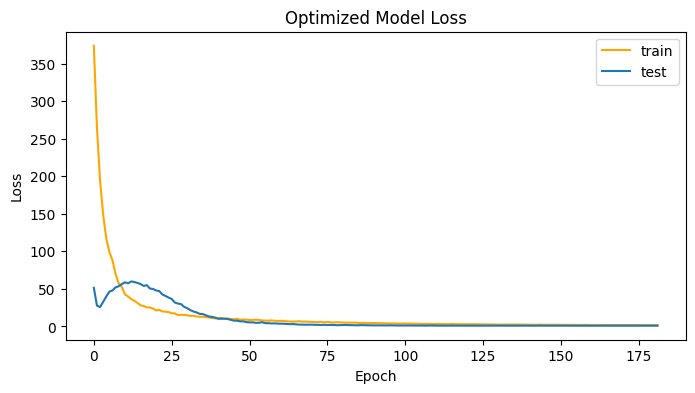

In [184]:
plt.figure(figsize=(8,4))
plt.plot(hist.history['loss'], color = 'orange')
plt.plot(hist.history['val_loss'])
plt.title('Optimized Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [185]:
#Se realiza prediccion
results = best_model.predict(X_test)
results = results.reshape(shape_y_test)
y_grafico = Y_test.reshape(shape_y_test)

19/19 [==============================] - 0s 2ms/step


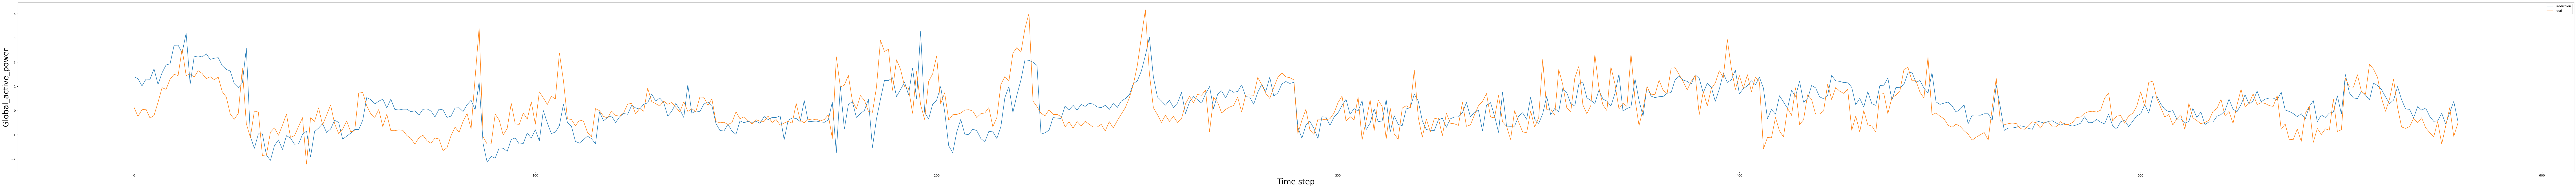

In [186]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(y_grafico.shape[0])]
plt.figure(figsize=(150,10))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=25)
plt.plot(tiempo,y_grafico)
plt.xlabel('Time step', size=25)
plt.legend(['Prediccion','Real'])
plt.show()

In [187]:
#Metricas de precision del modelo
score = best_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.7474936842918396
RMSE: 0.8645771741867065
MAE: 0.6606928706169128
MAPE: 313.1400451660156


#Exportar resultados

Se guardan los resultados la optimizacion bayesiana

In [188]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los parametros para exportalos a un csv
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for time in result['time']:
    k+=1
    nameModel = "Transformer_Wallmart"+"_"+str(trial)+"_"+str(k)  + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['head_size'])+"_"+str(result['params']['num_heads'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['ff_dim'])+"_"+str(result['params']['learning_rate'])
    results.append([nameModel,trial,k,time,
                    result['scores_test'][i][0],result['scores_test'][i][2],result['scores_test'][i][3],result['scores_test'][i][4]]
                   )
    i+=1

In [189]:
#Se crea dataframe
results_csv=pd.DataFrame(results,columns=['nameModel','trial_optimizacion_bayesiana','Step_validacion','time','MSE','RMSE','MAE','MAPE'])

In [190]:
results_csv

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
0,Transformer_Wallmart_1_1_800_50.0_192.0_5.0_0....,1,1,49.437145,8.697779,2.949200,2.435905,1509.784180
1,Transformer_Wallmart_1_2_800_50.0_192.0_5.0_0....,1,2,36.844944,16.964808,4.118836,3.434469,1885.262939
2,Transformer_Wallmart_1_3_800_50.0_192.0_5.0_0....,1,3,121.576889,3.928066,1.981935,1.513994,840.667725
3,Transformer_Wallmart_1_4_800_50.0_192.0_5.0_0....,1,4,103.134993,15.603485,3.950125,3.009809,1576.437988
4,Transformer_Wallmart_1_5_800_50.0_192.0_5.0_0....,1,5,10.969648,54.649776,7.392549,5.820982,3604.656982
...,...,...,...,...,...,...,...,...
245,Transformer_Wallmart_50_1_800_30.0_192.0_6.0_0...,50,1,25.150467,136.724091,11.692907,9.434134,5632.390625
246,Transformer_Wallmart_50_2_800_30.0_192.0_6.0_0...,50,2,12.825624,35.007378,5.916703,4.677658,2609.201904
247,Transformer_Wallmart_50_3_800_30.0_192.0_6.0_0...,50,3,127.967314,0.568534,0.754012,0.549807,271.508392
248,Transformer_Wallmart_50_4_800_30.0_192.0_6.0_0...,50,4,214.434890,0.544475,0.737886,0.553581,235.411942


In [191]:
results_o = results_csv.sort_values(by='MSE', ascending=True)
results_o.head(5)

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
172,Transformer_Wallmart_35_3_800_20.0_256.0_8.0_0...,35,3,248.451145,0.462994,0.680436,0.505869,187.493332
143,Transformer_Wallmart_29_4_800_40.0_128.0_7.0_0...,29,4,171.014874,0.469810,0.685427,0.517316,202.082199
17,Transformer_Wallmart_4_3_800_10.0_256.0_7.0_0....,4,3,460.828202,0.477908,0.691309,0.510906,201.069534
152,Transformer_Wallmart_31_3_800_20.0_96.0_7.0_0....,31,3,248.921013,0.482110,0.694341,0.523545,212.977966
178,Transformer_Wallmart_36_4_800_10.0_96.0_8.0_0....,36,4,298.431125,0.483665,0.695460,0.510977,192.902740


In [192]:
# Exportar el DataFrame como CSV
results_csv.to_csv('Narmax_results_Transformer_Wallmart.csv')

Se guarda cada modelo keras en un objeto Json

In [193]:
import os
# Ruta de la carpeta que deseas crear
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos/Narmax_result_Transformer'

# Verificar si la carpeta ya existe
if not os.path.exists(carpeta_destino):
    # Crear la carpeta si no existe
    os.makedirs(carpeta_destino)

In [194]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los modelos para exportalos a un Json
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for model in result['models']:
    k+=1
    nameModel = "Narmax_Transformer_Wallmart"+"_"+str(trial)+"_"+str(k)  + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['head_size'])+"_"+str(result['params']['num_heads'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['ff_dim'])+"_"+str(result['params']['learning_rate'])
    model_json = model.to_json()
    ruta = os.path.join(carpeta_destino, nameModel + ".json")
    with open(ruta, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    save_w=nameModel+"."+"h5"
    weights_path = os.path.join(carpeta_destino, save_w)
    model.save_weights(weights_path)
    i+=1